In [4]:


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchmetrics import MeanAbsolutePercentageError as MAPE
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import datetime, sys, os
import Dataset_Class as DC



# USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE = 'cpu'
RANDOM_SEED = 2023
EPOCHS = 50000
LEARNING_RATE = 0.000001
BATCH_SIZE = 16
# BATCH_SIZE = int(sys.argv[2])

# patience 3, batch_size 16, learning rate 0.000001, model(50-64-256-64-24) shows the best result



class Net(nn.Module):
    def __init__(self, col_len, **model_config):
        super(Net, self).__init__()
        self.model_type = model_config['case']
        if model_config['case'] == 1:
            self.hidd_dim = 512
            self.hidden_dim = 75
        elif model_config['case'] == 2:
            self.hidd_dim = 1500
            self.hidden_dim = 5000
            self.hidden_dimm = 300
        elif model_config['case'] == 3:
            self.hidd_dim = 500
            self.hidden_dim = 75  #good
        elif model_config['case'] == 4:
            self.hidd_dim = 250
            self.hidden_dim = 75
            
        self.fc1 = nn.Linear(col_len, self.hidd_dim)
        self.fc2 = nn.Linear(self.hidd_dim, self.hidden_dim)
        # self.fc3 = nn.Linear(self.hidden_dim, 24)
        self.fc3 = nn.Linear(self.hidden_dim, self.hidden_dimm)
        self.fc4 = nn.Linear(self.hidden_dimm, 24)
        self.relu = nn.ReLU()

    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        # output = self.fc3(x)
        x = self.fc3(x)
        x = self.relu(x)
        output = self.fc4(x)
        return output



# Set seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


# load the data and split into X and Y
def load_data(drop_features, building):
    if building == 'RISE':
        X_pv = pd.read_csv('./processed_data/pv/X_pv_231days_RISE.csv', index_col=0)
        Y_pv = pd.read_csv('./processed_data/pv/Y_pv_231days_RISE.csv', index_col=0)
    elif building == 'DORM':
        X_pv = pd.read_csv('./processed_data/pv/X_pv_231days_DORM.csv', index_col=0)
        Y_pv = pd.read_csv('./processed_data/pv/Y_pv_231days_DORM.csv', index_col=0)

    label_interval = get_label_interval(X_pv)
    if drop_features != 'No_drop':
        X = X_pv.drop(columns = drop_features)
    else:
        X = X_pv
        
    Y = Y_pv.iloc[:,0:24]
    col = X.columns
    col_len = len(col)
    X = torch.FloatTensor(X.values)
    Y = torch.FloatTensor(Y.values)
    return X, Y, col, col_len, label_interval


# split data into mini_train, valid, train, test
def split_data(X, Y, batch_size, data_len, train_pie, mini_train_pie):
    train_size = int(data_len * train_pie)
    mini_train_size = int(train_size * mini_train_pie)
    
    train_data = DC.CustomDataset(X[:train_size], Y[:train_size])
    test_data = DC.CustomDataset(X[train_size:], Y[train_size:])
    mini_train_data = DC.CustomDataset(X[:mini_train_size], Y[:mini_train_size])
    valid_data = DC.CustomDataset(X[mini_train_size:train_size], Y[mini_train_size:train_size])
    mini_train_dataloader = DataLoader(mini_train_data, batch_size = batch_size, shuffle = True)
    valid_dataloader = DataLoader(valid_data, batch_size = len(valid_data), shuffle = False)
    train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(test_data, batch_size = len(test_data), shuffle = False)
    
    return mini_train_dataloader, valid_dataloader, train_dataloader, test_dataloader, mini_train_size, train_size, test_data


# get the number of days of each month as label_interval list
def get_label_interval(X):
    label_interval = []
    for i in range(1, 13):
        cnt = 0
        for idx in X.index:
            if '21{0:0>2}'.format(i) in str(idx):
                cnt+=1
        label_interval.append(cnt)
    return label_interval
        
        

# create folder if not exist
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)


# plot daily feature graphs
def plot_daily_feature(X, label_interval, col_list, fig_size, font_size, mini_train_point, valid_point, pre_save_path):
    unit=''
    pv_col_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
    for idx, col in enumerate(col_list):
        if col in pv_col_list:
            if col == '0':
                data = torch.sum(X[:,idx:idx+24], axis=1).detach().numpy().reshape(-1)
                col = 'PV Generation'
                unit = 'kWh'
            else:
                continue
        elif 'DS' in col:
            # column: duration of sunshine
            data = X[:,idx]
            unit = 'hr'
        elif 'SL' in col:
            # column: sunlight
            data = X[:,idx]
            unit = 'hr'
        elif 'SR' in col:
            # column: solar radiation
            data = X[:,idx]
            unit = 'MJ/m2'
        elif 'TM_15' in col:
            #column: temperature of 15h on next day
            data = X[:,idx]
            unit = '℃'
        elif 'WS_15' in col:
            # column: wind speed of 15h on next day
            data = X[:,idx]
            unit = 'm/s'
        elif 'SK_15' in col:
            # column: state of sky of 15h on next day
            data = X[:,idx]
            col = 'SK_15'
            unit = '(1: clear, 3: partly cloudy, 4: cloudy)' 
        elif 'PP_15' in col:
            # column: probability of precipitation of 15h on next day
            data = X[:,idx]
            unit = '%'
        elif 'PR_15' in col:
            #column: precipitation of 15h on next day
            data = X[:,idx]
            unit = 'mm'
        else:
            continue

        # Create figure and plot the data
        fig = plt.figure(figsize=fig_size)
        ax = plt.axes()
        ax.plot(data)

        plt.title(col+" Fluctuation in 2021", fontsize = font_size)
        plt.xlabel('Month', fontsize = font_size)
        plt.ylabel(col+' ('+unit+')', fontsize = font_size)

        # Set the x-tick positions and labels
        x_ticks = []
        x_labels = []
        for i, interval in enumerate(label_interval):
            start = sum(label_interval[:i])
            x_ticks.append(start)
            x_labels.append(f'{i+1}')

        plt.axvline(x = mini_train_point, c='r')
        plt.axvline(x = valid_point, c='r')
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        
        # save the figure
        plt.savefig(pre_save_path+col+'.png')


def plot_loss(mini_train_loss_arr, val_loss_arr, range_start, best_val_epoch, fig_size, title, font_size, save_path):
    fig = plt.figure(figsize=fig_size)
    
    plt.subplot(221)
    plt.title(title, fontsize = font_size)
    # plt.xlabel('Epoch', fontsize = font_size)
    plt.ylabel('Loss(MSE)', fontsize = font_size)
    plt.plot(mini_train_loss_arr, c = 'blue', label = 'Train')
    plt.plot(val_loss_arr, c = 'orange', label = 'Validation')
    plt.legend(loc='upper right', fontsize = font_size)

    plt.subplot(222)
    plt.title(title+' from Epoch '+str(range_start)+' every epoch 200', fontsize = font_size)
    # plt.xlabel('Epoch', fontsize = font_size)
    plt.ylabel('Loss(MSE)', fontsize = font_size)
    plt.plot(np.arange(range_start, best_val_epoch, 200), mini_train_loss_arr[range_start:best_val_epoch:200], c = 'blue', label = 'Train')
    plt.plot(np.arange(range_start, best_val_epoch, 200), val_loss_arr[range_start:best_val_epoch:200], c = 'orange', label = 'Validation')
    plt.legend(loc='upper right', fontsize = font_size)

    plt.subplot(223)
    plt.title(title+' from Epoch '+str(range_start), fontsize = font_size)
    plt.xlabel('Epoch', fontsize = font_size)
    plt.ylabel('Loss(MSE)', fontsize = font_size)
    plt.plot(mini_train_loss_arr[range_start:], c = 'blue', label = 'Train')
    plt.legend(loc='upper right', fontsize = font_size)

    plt.subplot(224)
    plt.title(title+' from Epoch '+str(range_start), fontsize = font_size)
    plt.xlabel('Epoch', fontsize = font_size)
    plt.ylabel('Loss(MSE)', fontsize = font_size)
    plt.plot(val_loss_arr[range_start:], c = 'orange', label = 'Validation')
    plt.legend(loc='upper right', fontsize = font_size)

    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)
    
    # save the figure
    plt.savefig(save_path)



     
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    loss_sum = 0.0
    for (x, y) in train_dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        output = model(x)
        train_loss = criterion(output, y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        loss_sum += train_loss
    
    return (loss_sum/len(train_dataloader.dataset)/24).item() # loss of each epoch


def evaluate(model, valid_dataloader):
    model.eval()
    with torch.no_grad():
        for (x, y) in valid_dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
                
            output = model(x)
            
        return output, y


set_seed(RANDOM_SEED)
model_case = 2
building = 'RISE'
drop_features = 'No_drop'
mae = nn.L1Loss()
mape = MAPE()



# data loading
# X: 210104-211229, Y: 210105-211230 / 231*50
X, Y, col_list, col_len, label_interval = load_data(drop_features, building)
dataset = DC.CustomDataset(X, Y)
data_len = len(dataset)
mini_train_dataloader, valid_dataloader, train_dataloader, test_dataloader, mini_train_size, train_size, test_data =  split_data(X, Y, BATCH_SIZE, data_len, 0.8, 0.8)
# 147개   210104 ~ 210819
# 37개    210820 ~ 211015
# 184개   210104 ~ 211015
# 47개    211018 ~ 211229



# data plotting
dir = './experiment_outputs/pv_forecast/'
now = datetime.datetime.now()
timestamp = now.strftime("%m%d_%H%M")

file_name = f'{building}_{timestamp}_{model_case}_{drop_features}_{EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}'
_path = dir+"plots/daily_pv_features/"+file_name
create_folder(_path)
# plot_daily_feature(X, label_interval, col_list, (10,2.5), 8, mini_train_size-1, train_size-1, _path+'/')


# model setting
model_config = {'case': model_case}
model = Net(col_len, **model_config).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss(reduction='sum').to(DEVICE)
criterion2 = nn.MSELoss(reduction = 'mean').to(DEVICE)


# file to save the results
f = open(dir+f"results/{file_name}.txt", 'w')


# model training and validation
mini_train_loss_arr = []
val_loss_arr = []

best_val_loss = float('inf')
best_val_epoch = 0
patience = 0



# load state_dict from model.pt file
model.load_state_dict(torch.load('./experiment_outputs/pv_forecast/models/RISE_0328_1504_2_No_drop_50000_1e-06_16.pt'))



<All keys matched successfully>

In [10]:
test_data.Y[0]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.9000,
        10.7000, 25.7000, 37.3000, 44.7000, 48.6000, 48.6000, 45.0000, 37.3000,
        26.2000, 10.2000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])

In [28]:
Y_pv = pd.read_csv('./processed_data/pv/Y_pv_231days_RISE.csv', index_col=0)

test_y_idx = list(Y_pv.loc[211018:].index)


In [29]:
print(test_y_idx)
print(len(test_y_idx))

[211018, 211019, 211020, 211021, 211022, 211025, 211026, 211027, 211028, 211101, 211102, 211103, 211104, 211105, 211108, 211109, 211110, 211111, 211112, 211115, 211116, 211118, 211119, 211122, 211123, 211124, 211125, 211126, 211129, 211201, 211202, 211203, 211206, 211207, 211208, 211209, 211213, 211214, 211215, 211216, 211217, 211220, 211221, 211227, 211228, 211229, 211230]
47


In [90]:
test_output, test_y = evaluate(model, test_dataloader)
test_output = torch.where(test_output > 0, test_output, 0)
test_output[:,0:6] = 0
test_output[:, 21:] = 0

In [57]:
# 1517
mape_sum = 0
mean_test_y = 0
cnt=0
for i, tensor in enumerate(test_y):
    for j, value in enumerate(tensor):
        if value != 0:
            output = test_output[i][j]
            mape_sum += (abs(output - value) / value)
            # print(i, j, output, value, abs(output - value) / value)
            cnt += 1
            mean_test_y+=value

mean_test_y /= cnt

print(mape_sum)
print(mape_sum/cnt)
print(mean_test_y)            

tensor(633.5475)
tensor(1.3508)
tensor(19.7254)


In [98]:
    
def plot(i, length, output, Y, fig_size, title, font_size, save_path):
    fig = plt.figure(figsize=fig_size)
    ax = plt.axes()
    ax.plot(Y.detach().numpy()[i:i+length,:].reshape(-1), c='blue', label = 'Actual data')
    ax.plot(output.detach().numpy()[i:i+length,:].reshape(-1), c='red', label = 'forecast data')
    
    plt.title(title, fontsize = font_size)
    plt.xlabel('Time (h)', fontsize = font_size)
    plt.ylabel('PV (kWh)', fontsize = font_size)

    # Set the x-tick positions and labels
    x_ticks = []
    x_labels = []
    
    for i in range(0, 24*(length+1), 24):
        x_ticks.append(i)
        x_labels.append(f'{i//24}')
        
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)


    plt.legend(loc='lower right', fontsize = 13)
    plt.savefig(save_path)

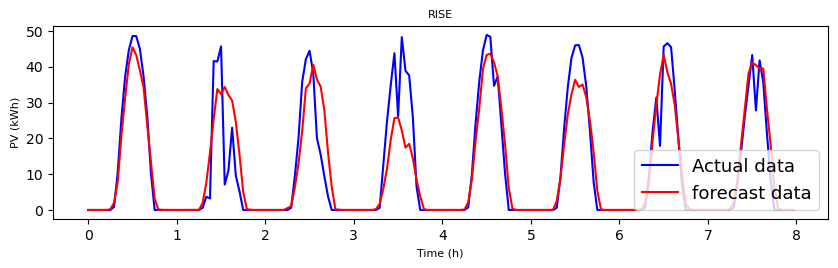

In [99]:
plot(0, 8, test_output, test_y, (10,2.5), 'RISE', 8, './experiment_outputs/pv_forecast/plots/RISE_0328_1504_2_No_drop_50000_1e-06_16.png')

In [58]:
# 1517, 평균보다 클 때만

mape_sum = 0
mean_test_y_upper_mean = 0
cnt=0
for i, tensor in enumerate(test_y):
    for j, value in enumerate(tensor):
        if value != 0 and value > mean_test_y:
            output = test_output[i][j]
            mape_sum += (abs(output - value) / value)
            mean_test_y_upper_mean += value
            # print(i, j, output, value, abs(output - value) / value)
            cnt += 1


print(mape_sum)
print(mape_sum/cnt)
print(mean_test_y_upper_mean/cnt)
            

tensor(58.0576)
tensor(0.2739)
tensor(34.3443)


In [45]:
# 1504

mape_sum = 0
mean_test_y = 0
cnt=0
for i, tensor in enumerate(test_y):
    for j, value in enumerate(tensor):
        if value != 0:
            output = test_output[i][j]
            mape_sum += (abs(output - value) / value)
            # print(i, j, output, value, abs(output - value) / value)
            cnt += 1
            mean_test_y+=value

mean_test_y /= cnt

print(mape_sum)
print(mape_sum/cnt)
print(mean_test_y)  
            

tensor(633.5475)
tensor(1.3508)
tensor(19.7254)


In [46]:
# 1504, 평균보다 클 때만

mape_sum = 0
cnt=0
for i, tensor in enumerate(test_y):
    for j, value in enumerate(tensor):
        if value != 0 and value > mean_test_y:
            output = test_output[i][j]
            mape_sum += (abs(output - value) / value)
            # print(i, j, output, value, abs(output - value) / value)
            cnt += 1

print(mape_sum)
print(mape_sum/cnt)
            

tensor(58.0576)
tensor(0.2739)
